In [129]:
# import tensorflow as tf
# import keras
import pandas as pd
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.linear_model import LinearRegression

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from tqdm import tqdm_notebook
import seaborn as sns

from sklearn.model_selection import train_test_split

import pickle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score

In [130]:
from IPython.display import display

In [131]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [132]:
players = pd.read_csv('/home/ryan/ml/tennis_ml/tennis_atp/atp_players.csv', 
                      header=None, 
                      names=['player_id', 'first_name', 'last_name', 'hand', 'birthday','country_code'])

In [133]:
players

,player_id,first_name,last_name,hand,birthday,country_code
0,100001,Gardnar,Mulloy,R,19131122.0,USA
1,100002,Pancho,Segura,R,19210620.0,ECU
2,100003,Frank,Sedgman,R,19271002.0,AUS
3,100004,Giuseppe,Merlo,R,19271011.0,ITA
4,100005,Richard Pancho,Gonzales,R,19280509.0,USA
...,...,...,...,...,...,...
54896,209862,Marco,Franzini,U,20010312.0,ITA
54897,209863,Leo,Borg,U,20030515.0,SWE
54898,209864,Tommaso,Compagnucci,U,NaN,ITA
54899,209865,Peter Benjamin,Privara,U,NaN,SVK


In [134]:
players.loc[players['last_name']=='Ruud']

,player_id,first_name,last_name,hand,birthday,country_code
2103,102104,Christian,Ruud,R,19720824.0,NOR
34754,134770,Casper,Ruud,R,19981222.0,NOR


In [135]:
#read all CSVs here and concatenate to form one dataframe
# df = pd.read_csv('/home/ryan/ml/tennis_ml/tennis_atp/atp_matches_2019.csv')

#enter years form which to take data: [start, end]
years = [2000, 2020]
df = pd.DataFrame()

for year in np.arange(years[0], years[1]+1):
    df_year = pd.read_csv(f'/home/ryan/ml/tennis_ml/tennis_atp/atp_matches_{year}.csv')
    df = pd.concat([df,df_year])

In [136]:
df.columns = ['tourney_id','tourney_name', 'surface', 'draw_size', 'tourney_level', 'tourney_date', 'match_num', 'w_id', 'w_seed', 'w_entry', 'w_name', 'w_hand', 'w_ht',
              'w_ioc', 'w_age', 'l_id', 'l_seed', 'l_entry', 'l_name', 'l_hand', 'l_ht', 'l_ioc', 'l_age', 'score', 'best_of', 'round', 'minutes',
              'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved',
              'l_bpFaced', 'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points']

In [137]:
list(df.columns.values)

['tourney_id',
 'tourney_name',
 'surface',
 'draw_size',
 'tourney_level',
 'tourney_date',
 'match_num',
 'w_id',
 'w_seed',
 'w_entry',
 'w_name',
 'w_hand',
 'w_ht',
 'w_ioc',
 'w_age',
 'l_id',
 'l_seed',
 'l_entry',
 'l_name',
 'l_hand',
 'l_ht',
 'l_ioc',
 'l_age',
 'score',
 'best_of',
 'round',
 'minutes',
 'w_ace',
 'w_df',
 'w_svpt',
 'w_1stIn',
 'w_1stWon',
 'w_2ndWon',
 'w_SvGms',
 'w_bpSaved',
 'w_bpFaced',
 'l_ace',
 'l_df',
 'l_svpt',
 'l_1stIn',
 'l_1stWon',
 'l_2ndWon',
 'l_SvGms',
 'l_bpSaved',
 'l_bpFaced',
 'winner_rank',
 'winner_rank_points',
 'loser_rank',
 'loser_rank_points']

In [138]:
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,w_id,w_seed,w_entry,w_name,w_hand,w_ht,w_ioc,w_age,l_id,l_seed,l_entry,l_name,l_hand,l_ht,l_ioc,l_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2000-301,Auckland,Hard,32,A,20000110,1,103163,1,NaN,Tommy Haas,R,188.0,GER,21.771389,101543,NaN,NaN,Jeff Tarango,L,180.0,USA,31.137577,7-5 4-6 7-5,3,R32,108.0,18.0,4.0,96.0,49.0,39.0,28.0,17.0,3.0,5.0,7.0,8.0,106.0,55.0,39.0,29.0,17.0,4.0,7.0,11.0,1612.0,63.0,595.0
1,2000-301,Auckland,Hard,32,A,20000110,2,102607,NaN,Q,Juan Balcells,R,190.0,ESP,24.558522,102644,NaN,NaN,Franco Squillari,L,183.0,ARG,24.386037,7-5 7-5,3,R32,85.0,5.0,3.0,76.0,52.0,39.0,13.0,12.0,5.0,6.0,5.0,10.0,74.0,32.0,25.0,18.0,12.0,3.0,6.0,211.0,157.0,49.0,723.0
2,2000-301,Auckland,Hard,32,A,20000110,3,103252,NaN,NaN,Alberto Martin,R,175.0,ESP,21.390828,102238,NaN,NaN,Alberto Berasategui,R,173.0,ESP,26.535250,6-3 6-1,3,R32,56.0,0.0,0.0,55.0,35.0,25.0,12.0,8.0,1.0,1.0,0.0,6.0,56.0,33.0,20.0,7.0,8.0,7.0,11.0,48.0,726.0,59.0,649.0
3,2000-301,Auckland,Hard,32,A,20000110,4,103507,7,NaN,Juan Carlos Ferrero,R,183.0,ESP,19.909651,103819,NaN,NaN,Roger Federer,R,185.0,SUI,18.422998,6-4 6-4,3,R32,68.0,5.0,1.0,53.0,28.0,26.0,15.0,10.0,0.0,0.0,11.0,2.0,70.0,43.0,29.0,14.0,10.0,6.0,8.0,45.0,768.0,61.0,616.0
4,2000-301,Auckland,Hard,32,A,20000110,5,102103,NaN,Q,Michael Sell,R,180.0,USA,27.381246,102765,4,NaN,Nicolas Escude,R,185.0,FRA,23.770021,0-6 7-6(7) 6-1,3,R32,115.0,1.0,2.0,98.0,66.0,39.0,14.0,13.0,6.0,11.0,8.0,8.0,92.0,46.0,34.0,18.0,12.0,5.0,9.0,167.0,219.0,34.0,873.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,2020-8996,Santiago,Clay,32,A,20200224,276,106148,NaN,NaN,Roberto Carballes Baena,R,NaN,ESP,26.924025,144719,NaN,NaN,Jaume Munar,R,NaN,ESP,22.806297,6-4 4-6 6-4,3,R32,158.0,0.0,4.0,93.0,73.0,45.0,11.0,15.0,6.0,10.0,1.0,3.0,109.0,69.0,45.0,18.0,15.0,9.0,14.0,97.0,614.0,105.0,548.0
634,2020-8996,Santiago,Clay,32,A,20200224,275,122669,NaN,LL,Juan Pablo Varillas,R,NaN,PER,24.386037,106110,NaN,Q,Filip Horansky,R,NaN,SVK,27.129363,6-4 6-2,3,R32,70.0,2.0,0.0,49.0,27.0,21.0,12.0,9.0,3.0,4.0,3.0,1.0,49.0,24.0,15.0,13.0,9.0,2.0,6.0,146.0,380.0,164.0,296.0
635,2020-8996,Santiago,Clay,32,A,20200224,273,105643,7,NaN,Federico Delbonis,L,190.0,ARG,29.388090,105373,NaN,Q,Martin Klizan,L,190.0,SVK,30.622861,6-1 7-6(5),3,R32,97.0,4.0,4.0,72.0,51.0,36.0,11.0,10.0,6.0,8.0,3.0,2.0,59.0,35.0,22.0,11.0,9.0,3.0,7.0,85.0,676.0,158.0,315.0
636,2020-8996,Santiago,Clay,32,A,20200224,272,106099,NaN,NaN,Salvatore Caruso,R,NaN,ITA,27.192334,106075,NaN,NaN,Jozef Kovalik,R,NaN,SVK,27.304586,6-2 6-3,3,R32,79.0,0.0,0.0,42.0,35.0,28.0,5.0,8.0,2.0,2.0,4.0,7.0,67.0,26.0,17.0,17.0,9.0,7.0,11.0,100.0,600.0,120.0,447.0


#### create player dictionary

In [139]:
#unique ids in the csv
ids = pd.concat([df['w_id'], df['l_id']]).unique()

In [23]:
# from multiprocessing import Pool
# pool = Pool(processes=4) # start 4 worker processes

In [140]:
###iterate through player ids and collect features

#instantiate a new dictionary to keep track of player stats
#this will be useful for diffing them later to create input-target pairs
pid_dict = {}
    
for target_pid in tqdm_notebook(ids):
    ### get features from whether the target player won or lost
    df2 = df[(df.loc[:,'w_id'] == target_pid ) | (df.loc[:,'l_id'] == target_pid)]

    ###create target column here
    y = [1 if pid==target_pid else 0 for pid in df2.w_id.values]
    y = pd.DataFrame(data=y, columns=['target'])

    ###switch up the dataframe to account for losses since after 
    ###taking target into account, we dont care about winner/loser specific columns
    swapped_features = ['age', 'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']
    for swapFeat in swapped_features:
        df2.loc[(y.target.values == 0), f'w_{swapFeat}'] = df2.loc[(y.target.values == 0), f'l_{swapFeat}']

    ### sort by tournament date and match number so features are sequential/time-dependant
    df2 = df2.sort_values(['tourney_date', 'match_num'], ascending=[True, True])

    #define list of features
    features = ['surface', 'round', 'w_age', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced']
    
    #drop rows with features of NaN
    #just ignoring these entries for now - can replace by adding averages in instead
    df2 = df2.dropna(subset=features)
    
    ###extract stats from features
    segments = df2.shape[0]    
    x_tr = extract_stats(df2, segments, features, scale=False)   

    df2.reset_index(drop=True, inplace=True)
    x_tr.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

    x_tr = pd.concat([df2['tourney_date'], df2['match_num'], x_tr], axis=1)

    # ### save to dictionary by PID
    pid_dict.update({f'{target_pid}' : x_tr})

/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice.
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: Mean of empty slice.
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in true_divide
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in true_divide
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide


In [141]:
# pickle.dump(pid_dict, open("/home/ryan/ml/tennis_ml/tennis-ml/saved_dictionaries/player_dict_030720.pckl", "wb"))
pid_dict = pickle.load( open( "/home/ryan/ml/tennis_ml/tennis-ml/saved_dictionaries/player_dict_030720.pckl", "rb" ) )

# pickle.dump(pid_dict, open("/home/ryan/ml/tennis_ml/tennis-ml/saved_dictionaries/player_dict_030620.pckl", "wb"))
# pid_dict = pickle.load( open( "/home/ryan/ml/tennis_ml/tennis-ml/saved_dictionaries/player_dict_030620.pckl", "rb" ) )

# pickle.dump(pid_dict, open("/home/ryan/ml/tennis_ml/tennis-ml/saved_dictionaries/player_dict_030520.pckl", "wb" ))
# pid_dict = pickle.load( open( "/home/ryan/ml/tennis_ml/tennis-ml/saved_dictionaries/player_dict_030520.pckl", "rb" ) )

In [142]:
#avoid any NaN entries since these werent captured in the player dictionary
features = ['surface', 'round', 'w_age', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced',
           'l_age', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced']
df = df.dropna(subset=features)

In [143]:
#all ids considered 
ids = pd.concat([df['w_id'], df['l_id']]).unique()
print(ids.shape)
idx = [] #indicies

#remove any empty entries
for i, target_pid in enumerate(ids):
    if pid_dict[f'{target_pid}'].empty:
        del pid_dict[f'{target_pid}']
        idx.append(i)

(1567,)


In [144]:
ids = np.delete(ids, idx)
print(ids.shape)

(1567,)


#### create input-target pairs

In [187]:
#tournament date cutoff for validation data
train_start_date = 20000101 
val_tourney_date = 20190901  #val set
test_tourney_date = 20200224 #hold out test-set

#number of rows before/equal to cutoff date
# train_rows = (df['tourney_date'] < val_tourney_date).value_counts()[1]
train_rows = ((df['tourney_date'] >= train_start_date) & (df['tourney_date'] < val_tourney_date)).value_counts()[1]
val_rows = ((df['tourney_date'] >= val_tourney_date) & (df['tourney_date'] < test_tourney_date)).value_counts()[1]
test_rows = (df['tourney_date'] >= test_tourney_date).value_counts()[1]

print(f"Training samples: {train_rows}")
print(f"Val samples: {val_rows}")
print(f"Test samples: {test_rows}")

#number of statistical measures taken across features
#get the first key...
key = list(pid_dict.keys())[0]
num_stats = pid_dict[key].shape[1]-2

### iterate throught the main dataframe to link up player-ids
### and pull information from the respective dictionary index to form input-target pairs

#additional features
add_features = ['w_rank', 'l_rank']
total_stats = num_stats + len(add_features)

x_train = np.empty(shape=(int(train_rows*2), total_stats))
y_train = np.empty(shape=(int(train_rows*2), 1))

x_val = np.empty(shape=(int(val_rows*2), total_stats))
y_val = np.empty(shape=(int(val_rows*2), 1))

x_test = np.empty(shape=(int(test_rows*2), total_stats))
y_test = np.empty(shape=(int(test_rows*2), 1))

### get features from whether the target player won or lost
df = df.sort_values(['tourney_date', 'match_num'], ascending=[True, True])

#initialize counters
j, k, l = 0, 0, 0

#loop through each row in the original dataframe
for winner_id, loser_id, w_rank, l_rank, tdate, match_num in tqdm_notebook(zip(df.w_id.values, df.l_id.values, df.winner_rank.values, df.loser_rank.values, df.tourney_date.values, df.match_num.values)):
    
    #extract features from player maps
        
#     features_w = np.asarray(pid_dict[f'{winner_id}'].loc[(pid_dict[f'{winner_id}']['tourney_date'] == tdate) & \
#                                                          (pid_dict[f'{winner_id}']['match_num'] == match_num)].loc[:, 'surface':])[:1,:]

#     features_l = np.asarray(pid_dict[f'{loser_id}'].loc[(pid_dict[f'{loser_id}']['tourney_date'] == tdate) & \
#                                                         (pid_dict[f'{loser_id}']['match_num'] == match_num)].loc[:, 'surface':])[:1,:]

    #find previous match on same tourney date
    features_w = pid_dict[f'{winner_id}'].loc[(pid_dict[f'{winner_id}']['tourney_date'] == tdate) & (pid_dict[f'{winner_id}']['match_num'] < match_num)].loc[:, 'surface':][-1:] #take last row
    features_l = pid_dict[f'{loser_id}'].loc[(pid_dict[f'{loser_id}']['tourney_date'] == tdate) & (pid_dict[f'{loser_id}']['match_num'] < match_num)].loc[:, 'surface':][-1:]
    
    #find last match on previous tourney date if empty
    if features_w.empty:
        features_w = pid_dict[f'{winner_id}'].loc[(pid_dict[f'{winner_id}']['tourney_date'] < tdate)].loc[:, 'surface':][-1:] 
        
    if features_l.empty:
        features_l = pid_dict[f'{loser_id}'].loc[(pid_dict[f'{loser_id}']['tourney_date'] < tdate)].loc[:, 'surface':][-1:]
        
#     if not features_w.empty:
#         print(tdate, match_num)
#         display((pid_dict[f'{winner_id}']))
#         display(features_w)
        
#         display((pid_dict[f'{loser_id}']))
#         display(features_l)
#         break

    
    if (features_w.empty) | (features_l.empty):
        #skip this entry...we are on one (or both) of the players first valid matches and have no prior data...
        if tdate < val_tourney_date:
            x_train[j,:] = -1.0
            y_train[j,0] = -1.0
            x_train[j+1,:] = -1.0
            y_train[j+1,0] = -1.0

            #increment counter
            j+=2
        elif (tdate >= val_tourney_date) & (tdate < test_tourney_date):
            x_val[k,:] = -1.0
            y_val[k,0] = -1.0
            x_val[k+1,:] = -1.0
            y_val[k+1,0] = -1.0

            #increment counter
            k+=2
        else:
            x_test[l,:] = -1.0
            y_test[l,0] = -1.0
            x_test[l+1,:] = -1.0
            y_test[l+1,0] = -1.0

            #increment counter
            l+=2
        
        #go next iteration
        continue   
    
    
    #np array conversion
    features_w = np.asarray(features_w)[:1,:]
    features_l = np.asarray(features_l)[:1,:]
     
    
    #add to train or validation set based on cutoff date chosen
    if tdate < val_tourney_date:
        ### add to x_train array
        x_train[j,:2] = features_w[0,:2] #add common items (surface and round type)
        x_train[j,2] = w_rank #add winner/loser ranks
        x_train[j,3] = l_rank
        x_train[j,4:] = features_w[0,2:] - features_l[0,2:]
        y_train[j,0] = 1.0

        #diff the features from loser to winner and count as a loss
        x_train[j+1,:2] = features_w[0,:2]
        x_train[j+1,2] = l_rank #switch
        x_train[j+1,3] = w_rank
        x_train[j+1,4:] = features_l[0,2:] - features_w[0,2:]
        y_train[j+1,0] = 0.0

        #increment counter
        j+=2
    elif (tdate >= val_tourney_date) & (tdate < test_tourney_date):
        ### add to x_val array
        x_val[k,:2] = features_w[0,:2]
        x_val[k,2] = w_rank #add winner/loser ranks
        x_val[k,3] = l_rank
        x_val[k,4:] = features_w[0,2:] - features_l[0,2:]
        y_val[k,0] = 1.0

        #diff the features from loser to winner and count as a loss
        x_val[k+1,:2] = features_w[0,:2]
        x_val[k+1,2] = l_rank #switch
        x_val[k+1,3] = w_rank
        x_val[k+1,4:] = features_l[0,2:] - features_w[0,2:]
        y_val[k+1,0] = 0.0

        #increment counter
        k+=2
    else:
        ### add to x_test array
        x_test[l,:2] = features_w[0,:2]
        x_test[l,2] = w_rank #add winner/loser ranks
        x_test[l,3] = l_rank
        x_test[l,4:] = features_w[0,2:] - features_l[0,2:]
        y_test[l,0] = 1.0

        ##
        x_test[l+1,:2] = features_w[0,:2]        
        x_test[l+1,2] = l_rank #switch
        x_test[l+1,3] = w_rank
        x_test[l+1,4:] = features_l[0,2:] - features_w[0,2:]
        y_test[l+1,0] = 0.0

        #increment counter
        l+=2

Training samples: 55240
Val samples: 1023
Test samples: 89


In [188]:
# valid_test_dates = []
# valid_test_matches = []

# #loop through each row in the original dataframe
# for winner_id, loser_id, w_rank, l_rank, tdate, match_num in tqdm_notebook(zip(df.w_id.values, df.l_id.values, df.winner_rank, df.loser_rank, df.tourney_date.values, df.match_num.values)):
        
#     if tdate >= 20200224:
#         #find previous match on same tourney date
#         features_w = pid_dict[f'{winner_id}'].loc[(pid_dict[f'{winner_id}']['tourney_date'] == tdate) & (pid_dict[f'{winner_id}']['match_num'] < match_num)].loc[:, 'surface':][-1:] #take last row
#         features_l = pid_dict[f'{loser_id}'].loc[(pid_dict[f'{loser_id}']['tourney_date'] == tdate) & (pid_dict[f'{loser_id}']['match_num'] < match_num)].loc[:, 'surface':][-1:]

#         #find last match on previous tourney date if empty
#         if (features_w.empty) | (features_l.empty):
#             features_w = pid_dict[f'{winner_id}'].loc[(pid_dict[f'{winner_id}']['tourney_date'] < tdate)].loc[:, 'surface':][-1:]
#             features_l = pid_dict[f'{loser_id}'].loc[(pid_dict[f'{loser_id}']['tourney_date'] < tdate)].loc[:, 'surface':][-1:]

#         if (features_w.empty) | (features_l.empty):
#             continue
#         else:
#             idx.append(df.)
    

In [189]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(110480, 752)
(2046, 752)
(178, 752)


In [46]:
#old
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(58060, 514)
(1718, 514)
(178, 514)


In [190]:
x_train = x_train[~np.all(x_train == -1, axis=1)]
y_train = y_train[~np.all(y_train == -1, axis=1)]

x_val = x_val[~np.all(x_val == -1, axis=1)]
y_val = y_val[~np.all(y_val == -1, axis=1)]

x_test = x_test[~np.all(x_test == -1, axis=1)]
y_test = y_test[~np.all(y_test == -1, axis=1)]

In [191]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(107620, 752)
(2004, 752)
(176, 752)


In [149]:
len(pid_dict)

2297

# LGBM developement

### Random searh for hyperparameter optimization

In [192]:
#random search for hyperparameter optimization
param_test ={'num_leaves': sp_randint(50, 225), 
             'min_child_samples': sp_randint(100, 500), 
             'min_data_in_leaf': sp_randint(20,150), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'max_depth': [-1],
             'learning_rate': [0.01],
             'bagging_freq': [2, 3, 4, 5, 6, 7, 10],
             'bagging_fraction': np.linspace(0.6, 0.95, 10)}

fit_params={"early_stopping_rounds": 30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(x_val, y_val[:,0])],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [53]:
#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 250

clf = lgb.LGBMClassifier(max_depth=-1, 
                         random_state=7, 
                         silent=True, 
                         metric='None', 
                         n_jobs=8, 
                         n_estimators=2000,
                         objective='binary')

gs = RandomizedSearchCV(estimator=clf, 
                        param_distributions=param_test, 
                        n_iter=n_HP_points_to_test,
                        scoring='roc_auc',
                        cv=3,
                        refit=True,
                        random_state=7,
                        verbose=True)

In [ ]:
gs.fit(x_train, y_train[:,0], **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 250 candidates, totalling 750 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.756878
[200]	valid's auc: 0.764768
[300]	valid's auc: 0.773006
[400]	valid's auc: 0.777888
[500]	valid's auc: 0.782027
[600]	valid's auc: 0.785194
[700]	valid's auc: 0.78825
[800]	valid's auc: 0.790868
[900]	valid's auc: 0.793233
[1000]	valid's auc: 0.795379
[1100]	valid's auc: 0.797102
[1200]	valid's auc: 0.798793
[1300]	valid's auc: 0.800396
[1400]	valid's auc: 0.801736
[1500]	valid's auc: 0.803116
[1600]	valid's auc: 0.804272
[1700]	valid's auc: 0.805258
[1800]	valid's auc: 0.806346
[1900]	valid's auc: 0.807402
[2000]	valid's auc: 0.808291
Did not meet early stopping. Best iteration is:
[2000]	valid's auc: 0.808291
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.7511
[200]	valid's auc: 0.762404
[300]	valid's auc: 0.773179
[400]	valid's auc: 0.779796
[500]	valid's auc: 0.784871
[600]	valid's auc: 0.78875
[700]	valid's auc: 0.792556
[800]	valid's auc: 0.795818
[900]	vali

In [ ]:
print(gs.best_params_)

### Train with optimal params

In [ ]:
# using LGBM lib here
# link to original work: https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf

In [193]:
params = {'bagging_fraction': 0.95,
          'bagging_freq': 4,
          'colsample_bytree': 0.5082709715216089,
          'learning_rate': 1e-02,
          'max_depth': -1,
          'min_child_samples': 230,
          'min_child_weight': 0.1,
          'min_data_in_leaf': 41,
          'num_leaves': 134,
          'reg_alpha': 2,
          'reg_lambda': 5,
          'subsample': 0.5319087827515545,
          'n_estimators' :10000,
          'objective':'binary',
          'n_jobs' : 8} 

# create dataset for lightgbm
lgb_train = lgb.Dataset(x_train, y_train[:,0])
lgb_valid = lgb.Dataset(x_val, y_val[:,0], reference=lgb_train)

# to record eval results for plotting
evals_result = {} 

# train
lgb_model = lgb.train(params,
                        lgb_train,
                        num_boost_round=200,
                        valid_sets=[lgb_train, lgb_valid],
                        evals_result=evals_result,
                        verbose_eval=10,
                        early_stopping_rounds=350)

/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 350 rounds
[10]	training's binary_logloss: 0.679988	valid_1's binary_logloss: 0.683192
[20]	training's binary_logloss: 0.668458	valid_1's binary_logloss: 0.674719
[30]	training's binary_logloss: 0.658722	valid_1's binary_logloss: 0.667353
[40]	training's binary_logloss: 0.649792	valid_1's binary_logloss: 0.660659
[50]	training's binary_logloss: 0.642453	valid_1's binary_logloss: 0.655555
[60]	training's binary_logloss: 0.635671	valid_1's binary_logloss: 0.65089
[70]	training's binary_logloss: 0.629873	valid_1's binary_logloss: 0.64731
[80]	training's binary_logloss: 0.624439	valid_1's binary_logloss: 0.644003
[90]	training's binary_logloss: 0.61964	valid_1's binary_logloss: 0.641072
[100]	training's binary_logloss: 0.615185	valid_1's binary_logloss: 0.638613
[110]	training's binary_logloss: 0.611015	valid_1's binary_logloss: 0.63616
[120]	training's binary_logloss: 0.606914	valid_1's binary_logloss: 0.63374
[130]	training's binary_logl

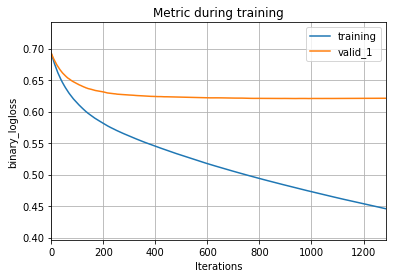

In [175]:
ax = lgb.plot_metric(evals_result, metric='binary_logloss')
plt.show()

In [184]:
#validation set prediction @ 0.5 threshold
y_pred_val = lgb_model.predict(x_val)
print(f'Validation-set acc: {accuracy_score(y_val, y_pred_val>0.50)*100:0.2f}%')

Validation-set acc: 64.83%


In [185]:
#test set prediction @ 0.5 threshold
y_pred_test = lgb_model.predict(x_test)
print(f'Hold-out Test-set acc: {accuracy_score(y_test, y_pred_test>0.50)*100:0.2f}%')

Hold-out Test-set acc: 71.59%


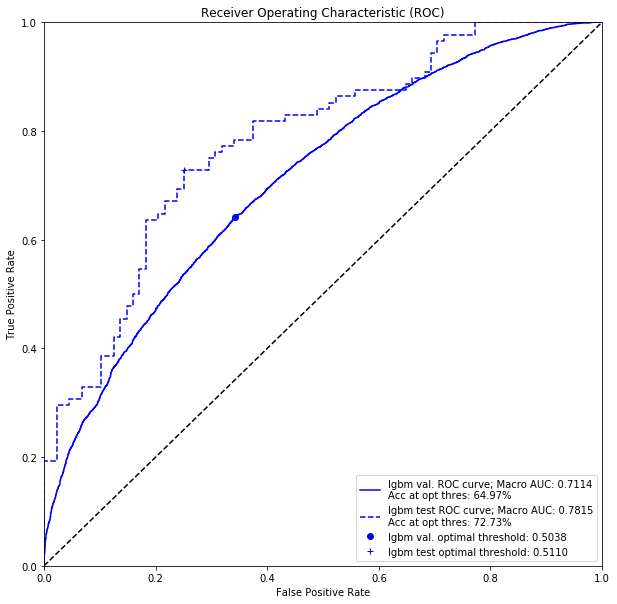

In [186]:
roc_curve_(models=[lgb_model],
           names=['lgbm'], 
           val_data=(x_val, y_val), 
           test_data=(x_test, y_test),
           colors=['b'])

In [197]:
pid_dict[key]

tourney_date  match_num  surface  round        age   ace_mean   ace_std  \
0        20000110          1      1.0    6.0  21.771389  18.000000  0.000000   
1        20000110         17      1.0    7.0  21.771389  13.500000  6.363961   
2        20000117         56      1.0    4.0  21.790554  14.666667  4.932883   
3        20000117         92      1.0    5.0  21.790554  11.250000  7.932003   
4        20000214         32      1.0    6.0  21.867214  10.600000  7.021396   
..            ...        ...      ...    ...        ...        ...       ...   
679      20170619        272      4.0    6.0  39.211499   7.058824  4.644291   
680      20170703        114      4.0    4.0  39.249829   7.060206  4.641015   
681      20170717        272      2.0    6.0  39.288159   7.052786  4.641652   
682      20170724        276      2.0    6.0  39.307324   7.046852  4.640839   
683      20170731        273      2.0    6.0  39.326489   7.046784  4.637441   

     ace_max  ace_min  ace_mean_change_abs  ace_abs_max  ace_abs_min  \
0       18.0     18.0             0.000000         18.0         18.0   
1       18.0      9.0            -9.000000         18.0          9.0   
2       18.0      9.0            -0.500000         18.0          9.0   
3       18.0      1.0            -5.666667         18.0          1.0   
4       18.0      1.0            -2.500000         18.0          1.0   
..       ...      ...                  ...          ...          ...   
679     24.0      0.0            -0.013255         24.0          0.0   
680     24.0      0.0            -0.014706         24.0          0.0   
681     24.0      0.0            -0.023495         24.0          0.0   
682     24.0      0.0            -0.021994         24.0          0.0   
683     24.0      0.0            -0.016105         24.0          0.0   

     ace_max_to_min_diff  ace_sum  ace_q95  ace_q99  ace_q05  ace_q01  \
0                    0.0     18.0    18.00    18.00    18.00    18.00   
1                    9.0     27.0    17.55    17.91     9.45     9.09   
2                    9.0     44.0    17.90    17.98     9.80     9.16   
3                   17.0     45.0    17.85    17.97     2.20     1.24   
4                   17.0     53.0    17.80    17.96     2.40     1.28   
..                   ...      ...      ...      ...      ...      ...   
679                 24.0   4800.0    16.00    20.00     1.00     0.00   
680                 24.0   4808.0    16.00    20.00     1.00     0.00   
681                 24.0   4810.0    16.00    20.00     1.00     0.00   
682                 24.0   4813.0    16.00    20.00     1.00     0.00   
683                 24.0   4820.0    16.00    20.00     1.00     0.00   

     ace_abs_q95  ace_abs_q99  ace_abs_q05  ace_abs_q01   ace_mad  ace_kurt  \
0          18.00        18.00        18.00        18.00  0.000000  0.000000   
1          17.55        17.91         9.45         9.09  4.500000  0.000000   
2          17.90        17.98         9.80         9.16  3.777778  0.000000   
3          17.85        17.97         2.20         1.24  6.250000 -1.514986   
4          17.80        17.96         2.40         1.28  5.520000 -1.199882   
..           ...          ...          ...          ...       ...       ...   
679        16.00        20.00         1.00         0.00  3.615917  0.732405   
680        16.00        20.00         1.00         0.00  3.612292  0.736280   
681        16.00        20.00         1.00         0.00  3.612783  0.737009   
682        16.00        20.00         1.00         0.00  3.612115  0.739958   
683        16.00        20.00         1.00         0.00  3.606888  0.745489   

     ace_skew  ace_med  ace_iqr  ace_q999  ace_q001  ace_ave10  \
0    0.000000     18.0     0.00    18.000    18.000  18.000000   
1    0.000000     13.5     4.50    17.991     9.009  13.500000   
2   -1.652317     17.0     4.50    17.998     9.016  14.666667   
3   -0.788991     13.0    10.25    17.997     1.024  11.250000   
4   -0.287733      9.0 

In [270]:
key = list(pid_dict.keys())[0]
key

'103163'

In [269]:
pid_dict[key]['ace_mean']

0      18.000000
1      13.500000
2      14.666667
3      11.250000
4      10.600000
         ...    
679     7.058824
680     7.060206
681     7.052786
682     7.046852
683     7.046784
Name: ace_mean, Length: 684, dtype: float64

7.329392070477547
0.06780671977853912


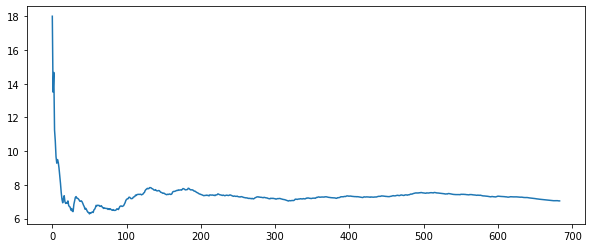

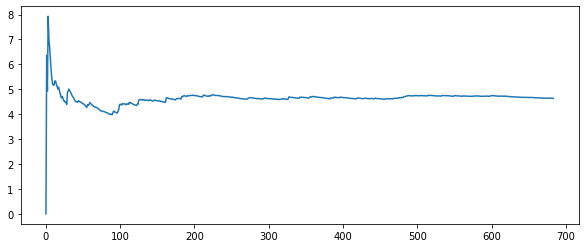

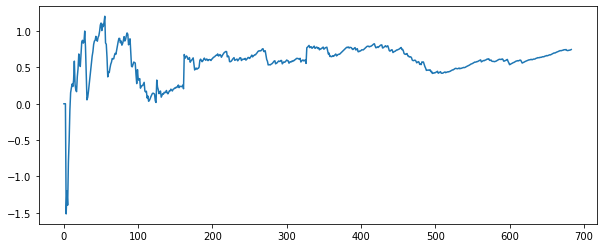

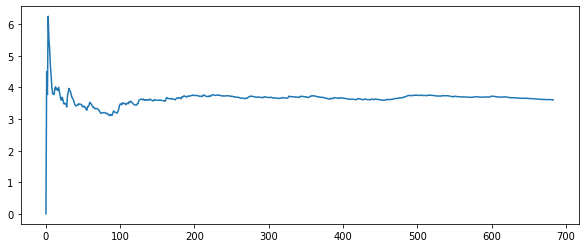

In [264]:
plt.figure(figsize=(10,4))

plt.plot(pid_dict[key]['ace_mean'])
last_games = 50
mean_ = np.mean(pid_dict[key]['ace_mean'][-last_games:])
# plt.axhline(mean_)
# plt.axhline(mean_+np.std(pid_dict[key]['ace_mean'][-last_games:]), color='r')
# plt.axhline(mean_-np.std(pid_dict[key]['ace_mean'][-last_games:]),color='r')
# plt.ylim([-0.05, 0.05])
print(np.mean(pid_dict[key]['ace_mean']))
print(np.std(pid_dict[key]['ace_mean'][-last_games:]))
plt.show()


plt.figure(figsize=(10,4))
plt.plot(pid_dict[key]['ace_std'])
plt.show()

plt.figure(figsize=(10,4))
plt.plot(pid_dict[key]['ace_kurt'])
plt.show()

plt.figure(figsize=(10,4))
plt.plot(pid_dict[key]['ace_mad'])
plt.show()

In [237]:
key

'103163'

In [273]:
df2 = df[(df.loc[:,'w_id'] == 103163) | (df.loc[:,'l_id'] == 103163)]

###create target column here
y = [1 if pid==103163 else 0 for pid in df2.w_id.values]
y = pd.DataFrame(data=y, columns=['target'])

###switch up the dataframe to account for losses since after 
###taking target into account, we dont care about winner/loser specific columns
swapped_features = ['age', 'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']
for swapFeat in swapped_features:
    df2.loc[(y.target.values == 0), f'w_{swapFeat}'] = df2.loc[(y.target.values == 0), f'l_{swapFeat}']

### sort by tournament date and match number so features are sequential/time-dependant
df2 = df2.sort_values(['tourney_date', 'match_num'], ascending=[True, True])

#define list of features
features = ['surface', 'round', 'w_age', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced']

#drop rows with features of NaN
#just ignoring these entries for now - can replace by adding averages in instead
df2 = df2.dropna(subset=features)

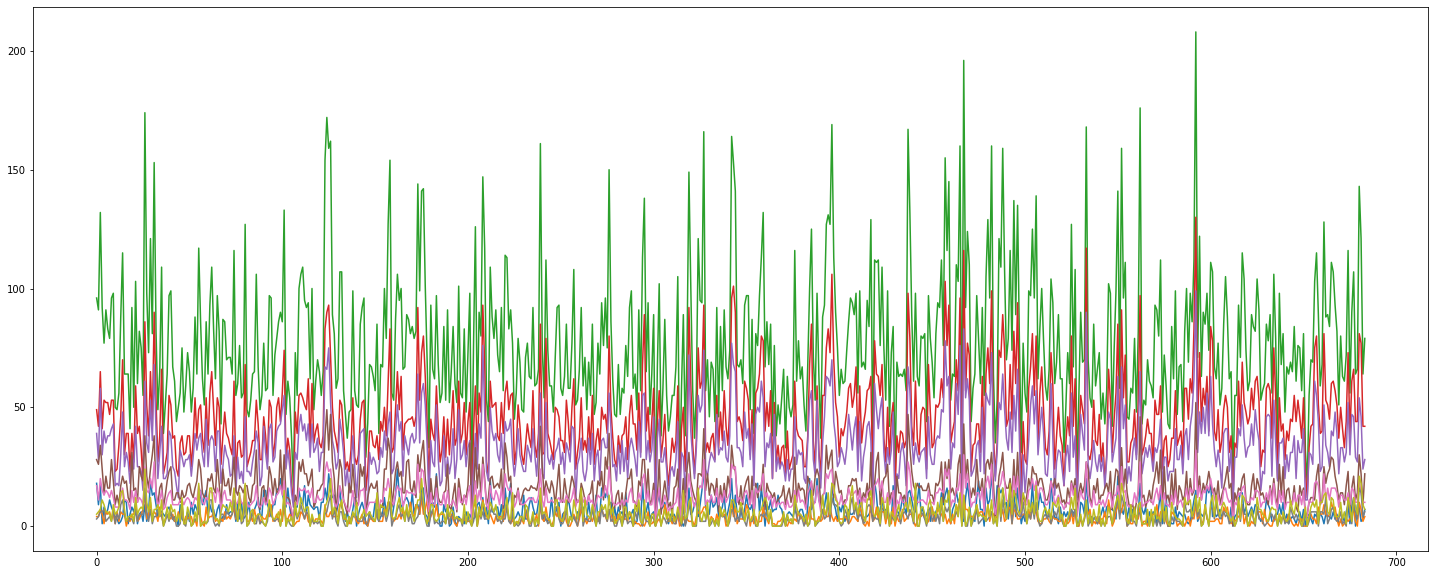

In [280]:
plt.figure(figsize=(25,10))
plt.plot(df2.w_ace.values)
plt.plot(df2.w_df.values)
plt.plot(df2.w_svpt.values)
plt.plot(df2.w_1stIn.values)
plt.plot(df2.w_1stWon.values)
plt.plot(df2.w_2ndWon.values)
plt.plot(df2.w_SvGms.values)
plt.plot(df2.w_bpSaved.values)
plt.plot(df2.w_bpFaced.values)

# XGBoost development

#### Random search for optimal hyperparameters

In [31]:
#random search for hyperparameter optimization
param_test ={'num_leaves': sp_randint(15, 150), 
             'min_child_samples': sp_randint(100, 500), 
             'min_data_in_leaf': sp_randint(20,150), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
             'learning_rate': [0.1, 0.01],
             'bagging_freq': [3, 4, 5, 6, 7],
             'bagging_fraction': np.linspace(0.6, 0.95, 10),
             'max_depth': [6, 10, 15, 20]}

fit_params={"early_stopping_rounds": 30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(x_val, y_val[:,0])],
            'verbose': 100}

n_HP_points_to_test = 250

clf = xgb.XGBClassifier(learning_rate=0.01,
                        n_estimators=5000,
                        objective= 'binary:logistic',
                        nthread=8,
                        eval_metric='auc',
                        seed=7)

gs_xgb = RandomizedSearchCV(estimator=clf, 
                            param_distributions=param_test, 
                            n_iter=n_HP_points_to_test,
                            scoring='roc_auc',
                            cv=3,
                            refit=True,
                            random_state=7,
                            verbose=True)

In [ ]:
gs_xgb.fit(x_train, y_train[:,0], **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

#### Train model with optimal parameters

In [ ]:
params = {'bagging_fraction': 0.95,
          'bagging_freq': 4,
          'colsample_bytree': 0.5082709715216089,
          'learning_rate': 1e-02,
          'max_depth': 15,
          'min_child_samples': 230,
          'min_child_weight': 0.1,
          'min_data_in_leaf': 41,
          'num_leaves': 134,
          'reg_alpha': 2,
          'reg_lambda': 5,
          'subsample': 0.5319087827515545} 

xgb_model = xgb.XGBClassifier(**params,
                              n_estimators=10000,
                              objective= 'binary:logistic',
                              nthread=8,
                              eval_metric='auc',
                              seed=7)

In [ ]:
xgb_model.fit(x_train, y_train[:,0],
              eval_set=[(x_train, y_train[:,0]), (x_val, y_val[:,0])],
              verbose=True,
              early_stopping_rounds=400)

In [ ]:
results = xgb_model.evals_result()

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(results['validation_0']['auc'], 'b', label='training set auc')
plt.plot(results['validation_1']['auc'], 'r', label='val set auc')
plt.show()

In [ ]:
roc_curve_(models=[xgb_model], 
           names=['xgb'], 
           val_data=(x_val, y_val),
           test_data=(x_test, y_test), 
           colors=['r'])

### CatBoost model 

In [66]:
cat_model = CatBoostClassifier(iterations=10000,
                               learning_rate=1e-02,
                               l2_leaf_reg=3.5,
                               depth=8,
                               rsm=0.98,
                               loss_function= 'Logloss',
                               eval_metric='AUC',
                               use_best_model=True,
                               random_seed=7)

In [ ]:
cat_model.fit(x_train, y_train,
              eval_set=(x_val, y_val),
              verbose=True,
              early_stopping_rounds=400)

In [ ]:
roc_curve_(models=[cat_model], 
           names=['cat'], 
           val_data=(x_val, y_val),
           test_data=(x_test, y_test), 
           colors=['k'])

# Multi-model Evaluation

### mutli-model ROC curve

In [ ]:
roc_curve_(models=[lgb_model, xgb_model, cat_model], 
           names=['lgb', 'xgb', 'cat'], 
           val_data=(x_val, y_val),
           test_data=(x_test, y_test), 
           colors=['b', 'r', 'k'])

### stacking evaluation

In [78]:
#LGBM predictions
y_pred_val_lgbm = lgb_model.predict(x_val)
y_pred_test_lgbm = lgb_model.predict(x_test)

#XGBoost predictions
# y_pred_val_xgb = xgb_model.predict_proba(x_val)[:,1]
# y_pred_test_xgb = xgb_model.predict_proba(x_test)[:,1]

#CatBoost predictions
y_pred_val_cat = cat_model.predict_proba(x_val)[:,1]
y_pred_test_cat = cat_model.predict_proba(x_test)[:,1]

#stacking
y_pred_val_stack = np.mean(np.vstack((y_pred_val_lgbm, y_pred_val_cat)), axis=0)
y_pred_test_stack = np.mean(np.vstack((y_pred_test_lgbm, y_pred_test_cat)), axis=0)

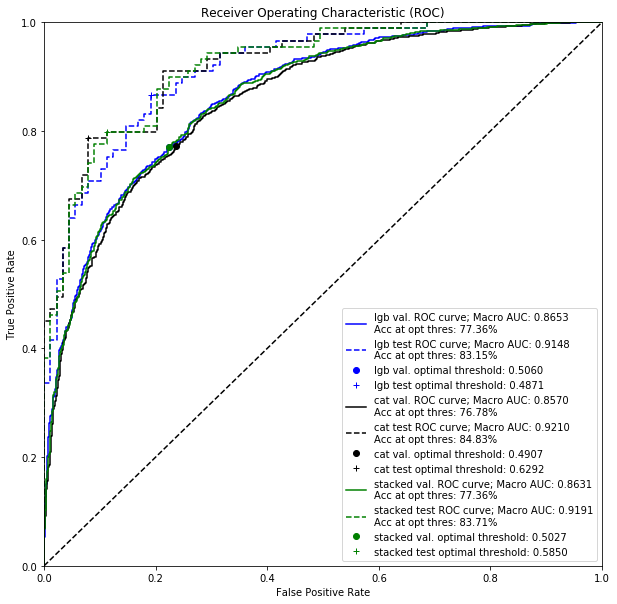

In [80]:
#include all models being tested
# models = ['lgb', 'xgb', 'cat', 'stacked']
# colors = ['b', 'r', 'k', 'g']

models = ['lgb', 'cat', 'stacked']
colors = ['b', 'k', 'g']

model_preds = [[y_pred_val_lgbm, y_pred_test_lgbm], 
#                [y_pred_val_xgb, y_pred_test_xgb],
               [y_pred_val_cat, y_pred_test_cat],
               [y_pred_val_stack, y_pred_test_stack]]

# Plot ROC curve
plt.figure(figsize=(10,10))

#lgbm
for i in range(len(models)):
    # Compute fpr, tpr, thresholds and roc auc
    fpr_val, tpr_val, thresholds_val = roc_curve(y_val, model_preds[i][0])
    mac_roc_auc_val = roc_auc_score(y_val, model_preds[i][0], average='macro')

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, model_preds[i][1])
    mac_roc_auc_test = roc_auc_score(y_test, model_preds[i][1], average='macro')

    #optimal threshold from ROC curve
    #minimum euclid distance between (0,1) threshold points
    min_arg_val = np.argmin(euclid_distance(fpr_val, tpr_val, opt_point=(0,1)))
    opt_thres_val = thresholds_val[min_arg_val]

    min_arg_test = np.argmin(euclid_distance(fpr_test, tpr_test, opt_point=(0,1)))
    opt_thres_test = thresholds_test[min_arg_test]
        
    y_pred_bin_val = model_preds[i][0] > opt_thres_val
    acc_at_opt_val = accuracy_score(y_val, y_pred_bin_val)
    
    y_pred_bin_test = model_preds[i][1] > opt_thres_test
    acc_at_opt_test = accuracy_score(y_test, y_pred_bin_test)
    
    plt.plot(fpr_val, tpr_val,colors[i], label=f'{models[i]} val. ROC curve; Macro AUC: {mac_roc_auc_val:0.4f}\nAcc at opt thres: {acc_at_opt_val*100:0.2f}%')
    plt.plot(fpr_test, tpr_test, f'{colors[i]}--', label=f'{models[i]} test ROC curve; Macro AUC: {mac_roc_auc_test:0.4f}\nAcc at opt thres: {acc_at_opt_test*100:0.2f}%')
    plt.plot(fpr_val[min_arg_val], tpr_val[min_arg_val], f'{colors[i]}o', label=f'{models[i]} val. optimal threshold: {opt_thres_val:0.4f}')
    plt.plot(fpr_test[min_arg_test], tpr_test[min_arg_test], f'{colors[i]}+', label=f'{models[i]} test optimal threshold: {opt_thres_test:0.4f}')
    
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Test set analysis

In [479]:
#test set prediction @ 0.5 threshold
y_pred_test = lgb_model.predict(x_test)
# y_pred_test_stack = np.mean(np.vstack((y_pred_test_lgbm, y_pred_test_cat)), axis=0)

print(f'Hold-out Test-set acc: {accuracy_score(y_test, y_pred_test>0.50)*100:0.2f}%')

Hold-out Test-set acc: 73.30%


In [480]:
playerA_win_mean_lst = []
playerA_win_std_lst = []
playerB_win_mean_lst = []
playerB_win_std_lst = []
new_lst = []

for i in range(0,y_pred_test.shape[0],2):
    playerA_win_mean_lst.append(f'{np.mean([y_pred_test[i]*100, (1-y_pred_test[i+1])*100]):0.4f}% ± {np.std([y_pred_test[i]*100, (1-y_pred_test[i+1])*100]):0.4f}%')
    new_lst.append(np.mean([y_pred_test[i], (1-y_pred_test[i+1])]))
    
    playerB_win_mean_lst.append(f'{np.mean([y_pred_test[i+1]*100, (1-y_pred_test[i])*100]):0.4f}% ± {np.std([y_pred_test[i+1]*100, (1-y_pred_test[i])*100]):0.4f}%')
    new_lst.append(np.mean([y_pred_test[i+1], (1-y_pred_test[i])]))

new_lst = np.asarray(new_lst)

In [481]:
print(f'Hold-out Test-set acc: {accuracy_score(y_test, new_lst>0.50)*100:0.2f}%')

Hold-out Test-set acc: 72.73%


In [482]:
test_df = df.loc[(df['tourney_date'] >= test_tourney_date)]
test_df = test_df[['tourney_id', 'tourney_name','surface','draw_size', 'tourney_level', 'tourney_date', 'match_num','w_name','w_id', 'winner_rank','l_name','l_id', 'loser_rank']]

In [483]:
outcome_lst = []
for w_rank, l_rank in zip(test_df.winner_rank, test_df.loser_rank):
    if w_rank < l_rank:
        outcome_lst.append('N')
    else:
        outcome_lst.append('U')
        
i_ratio = []
for w_id, l_id in zip(test_df.w_id, test_df.l_id):
    i_ratio.append(len(pid_dict[f'{w_id}']) / len(pid_dict[f'{l_id}']))

In [ ]:
test_df.insert(10, "probA", playerA_win_mean_lst) 
test_df.insert(14, "probB", playerB_win_mean_lst) 
test_df.insert(15, "Upset-by-rank", outcome_lst)
test_df.insert(16, "i-ratio", i_ratio)

In [ ]:
test_df.sort_values(by=['tourney_name', 'tourney_date','match_num'])

In [329]:
test_df.sort_values(by=['tourney_name', 'tourney_date','match_num'])

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,w_name,w_id,winner_rank,probA,l_name,l_id,loser_rank,probB,Upset-by-rank,i-ratio
579,2020-M004,Acapulco,Hard,32,A,20200224,270,Alexander Zverev,100644,7.0,99.9629% ± 0.0039%,Jason Jung,105359,119.0,0.0371% ± 0.0039%,N,15.545455
578,2020-M004,Acapulco,Hard,32,A,20200224,271,Tommy Paul,126205,66.0,90.0975% ± 1.9751%,Mackenzie McDonald,111456,196.0,9.9025% ± 1.9751%,N,0.750000
577,2020-M004,Acapulco,Hard,32,A,20200224,272,Marcos Giron,106218,115.0,58.2987% ± 0.5275%,Gerardo Lopez Villasenor,126204,518.0,41.7013% ± 0.5275%,N,3.000000
576,2020-M004,Acapulco,Hard,32,A,20200224,273,John Isner,104545,20.0,99.8532% ± 0.0031%,Mischa Zverev,104999,257.0,0.1468% ± 0.0031%,N,2.076687
575,2020-M004,Acapulco,Hard,32,A,20200224,274,Felix Auger Aliassime,200000,19.0,99.6339% ± 0.0867%,Alex Bolt,106109,137.0,0.3661% ± 0.0867%,N,3.916667
574,2020-M004,Acapulco,Hard,32,A,20200224,275,Kyle Edmund,106378,44.0,76.3213% ± 1.9530%,Feliciano Lopez,103852,52.0,23.6787% ± 1.9530%,N,0.244809
573,2020-M004,Acapulco,Hard,32,A,20200224,276,Taylor Fritz,126203,35.0,81.5200% ± 2.2976%,John Millman,105357,40.0,18.4800% ± 2.2976%,N,1.065089
572,2020-M004,Acapulco,Hard,32,A,20200224,277,Ugo Humbert,200005,43.0,84.8908% ± 0.2501%,Nick Kyrgios,106401,23.0,15.1092% ± 0.2501%,U,0.227642
571,2020-M004,Acapulco,Hard,32,A,20200224,278,Grigor Dimitrov,105777,22.0,99.9742% ± 0.0001%,Damir Dzumhur,106000,109.0,0.0258% ± 0.0001%,N,2.294118
570,2020-M004,Acapulco,Hard,32,A,20200224,279,Adrian Mannarino,105173,42.0,98.2211% ± 0.0185%,Cameron Norrie,111815,58.0,1.7789% ± 0.0185%,N,4.170000


## Real match prediction

#### first retrain model on all data so that its updated on all current player information

In [359]:
#ALL ROWS of full dataframe
dev_rows = df.shape[0]

#number of statistical measures taken across features
num_stats = pid_dict['100644'].shape[1]-2

### iterate throught the main dataframe to link up player-ids
### and pull information from the respective dictionary index to form input-target pairs

add_features = ['w_rank', 'l_rank']
total_stats = num_stats + len(add_features)

x_train_dev = np.empty(shape=(int(dev_rows*2), total_stats))
y_train_dev = np.empty(shape=(int(dev_rows*2), 1))

### get features from whether the target player won or lost
df = df.sort_values(['tourney_date', 'match_num'], ascending=[True, True])

#initialize counters
j = 0

#loop through each row in the original dataframe
for winner_id, loser_id, w_rank, l_rank, tdate, match_num in tqdm_notebook(zip(df.w_id.values, df.l_id.values, df.winner_rank, df.loser_rank, df.tourney_date.values, df.match_num.values)):
    
    #extract features from player maps
    features_w = np.asarray(pid_dict[f'{winner_id}'].loc[(pid_dict[f'{winner_id}']['tourney_date'] == tdate) & (pid_dict[f'{winner_id}']['match_num'] == match_num)].loc[:, 'surface':])[:1,:]
    features_l = np.asarray(pid_dict[f'{loser_id}'].loc[(pid_dict[f'{loser_id}']['tourney_date'] == tdate) & (pid_dict[f'{loser_id}']['match_num'] == match_num)].loc[:, 'surface':])[:1,:]

    ### add to x_train array
    x_train_dev[j,:2] = features_w[0,:2] #add common items (surface and round type)
    x_train_dev[j,2] = w_rank #add winner/loser ranks
    x_train_dev[j,3] = l_rank
    x_train_dev[j,4:] = features_w[0,2:] - features_l[0,2:]
    y_train_dev[j,0] = 1.0

    #diff the features from loser to winner and count as a loss
    x_train_dev[j+1,:2] = features_w[0,:2]

    x_train_dev[j+1,2] = w_rank #add winner/loser ranks
    x_train_dev[j+1,3] = l_rank

    x_train_dev[j+1,4:] = features_l[0,2:] - features_w[0,2:]
    y_train_dev[j+1,0] = 0.0

    #increment counter
    j+=2

In [360]:
params = {'bagging_fraction': 0.95,
          'bagging_freq': 4,
          'colsample_bytree': 0.5082709715216089,
          'learning_rate': 1e-02,
          'max_depth': -1,
          'min_child_samples': 230,
          'min_child_weight': 0.1,
          'min_data_in_leaf': 41,
          'num_leaves': 134,
          'reg_alpha': 2,
          'reg_lambda': 5,
          'subsample': 0.5319087827515545,
          'n_estimators' : 4200,
          'objective' : 'binary',
          'n_jobs' : 8} 

# create dataset for lightgbm
lgb_train = lgb.Dataset(x_train_dev, y_train_dev[:,0])

# train
lgb_model_dev = lgb.train(params,
                        lgb_train,
                        num_boost_round=200,
                        valid_sets=[lgb_train],
                        verbose_eval=10,
                        early_stopping_rounds=350)

/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 350 rounds
[10]	training's binary_logloss: 0.662926
[20]	training's binary_logloss: 0.638246
[30]	training's binary_logloss: 0.614222
[40]	training's binary_logloss: 0.59643
[50]	training's binary_logloss: 0.577081
[60]	training's binary_logloss: 0.559887
[70]	training's binary_logloss: 0.544222
[80]	training's binary_logloss: 0.528793
[90]	training's binary_logloss: 0.510479
[100]	training's binary_logloss: 0.49841
[110]	training's binary_logloss: 0.48755
[120]	training's binary_logloss: 0.477004
[130]	training's binary_logloss: 0.46723
[140]	training's binary_logloss: 0.456654
[150]	training's binary_logloss: 0.448048
[160]	training's binary_logloss: 0.43942
[170]	training's binary_logloss: 0.430847
[180]	training's binary_logloss: 0.423517
[190]	training's binary_logloss: 0.416693
[200]	training's binary_logloss: 0.410474
[210]	training's binary_logloss: 0.403831
[220]	training's binary_logloss: 0.397594
[230]	training's binary_logl

#### Enter current players here

In [380]:
# if (round_ == 'ER'):
# elif (round_ == 'BR'):
# elif (round_ == 'RR'):
# elif (round_ == 'R128'):
# elif (round_ == 'R64'):
# elif (round_ == 'R32'):
# elif (round_ == 'R16'):
# elif (round_ == 'QF'):
# elif (round_ == 'SF'):
# elif (round_ == 'F'):

#bet Londero
playerA_first_name, playerA_last_name = 'Juan Ignacio', 'Londero'  
playerB_first_name, playerB_last_name = 'Daniel Elahi', 'Galan Riveros'
round_ = 'QF'
surface_ = 'Hard'

# Probability that Juan Ignacio Londero wins: 97.22 ± 0.47%
# Probability that Daniel Elahi Galan Riveros wins: 2.78 ± 0.47%

#########################
playerA_first_name, playerA_last_name = 'Lukas', 'Rosol'
playerB_first_name, playerB_last_name = 'Jozef', 'Kovalik'
round_ = 'BR'
surface_ = 'Hard'

# Probability that Lukas Rosol wins: 73.20 ± 3.53%
# Probability that Jozef Kovalik wins: 26.80 ± 3.53%

################
playerA_first_name, playerA_last_name, playerA_rank = 'Leonardo', 'Mayer', 118
playerB_first_name, playerB_last_name, playerB_rank = 'Santiago', 'Giraldo', 292
round_ = 'R128' #no code for qualifiers?
surface_ = 'Hard'

# Probability that Leonardo Mayer wins: 81.41 ± 0.22%
# Probability that Santiago Giraldo wins: 18.59 ± 0.22%

##################

# playerA_first_name, playerA_last_name, playerA_rank = 'Jiri', 'Vesely', 64
# playerB_first_name, playerB_last_name, playerB_rank = 'Andrej', 'Martin', 95
# round_ = 'R128'
# surface_ = 'Hard'

# Probability that Jiri Vesely wins: 71.25 ± 1.26%
# Probability that Andrej Martin wins: 28.75 ± 1.26%

In [381]:
playerA_id = find_id(playerA_first_name, playerA_last_name)
playerB_id = find_id(playerB_first_name, playerB_last_name)

#most recent player A/B tournament date:
tdateA, match_numA = np.asarray(pid_dict[f'{playerA_id}'][['tourney_date', 'match_num']])[-1]
tdateB, match_numB = np.asarray(pid_dict[f'{playerB_id}'][['tourney_date', 'match_num']])[-1]

#gather features from player profile dictionaries
features_a = np.asarray(pid_dict[f'{playerA_id}'].loc[(pid_dict[f'{playerA_id}']['tourney_date'] == tdateA) & (pid_dict[f'{playerA_id}']['match_num'] == match_numA)].loc[:, 'surface':])
features_b = np.asarray(pid_dict[f'{playerB_id}'].loc[(pid_dict[f'{playerB_id}']['tourney_date'] == tdateB) & (pid_dict[f'{playerB_id}']['match_num'] == match_numB)].loc[:, 'surface':])

vect1 = features_a[0,2:] - features_b[0,2:]
vect2 = features_b[0,2:] - features_a[0,2:]

vect1 = np.insert(vect1, 0, playerB_rank, axis=0) #add playerB rank
vect1 = np.insert(vect1, 0, playerA_rank, axis=0) #add playerA rank
vect1 = np.insert(vect1, 0, get_round_cate(round_), axis=0) #add round
vect1 = np.insert(vect1, 0, get_surface_cate(surface_), axis=0) #add surface
vect1 = np.expand_dims(vect1, axis=0)

vect2 = np.insert(vect2, 0, playerB_rank, axis=0) #add playerB rank
vect2 = np.insert(vect2, 0, playerA_rank, axis=0) #add playerA rank
vect2 = np.insert(vect2, 0, get_round_cate(round_), axis=0)
vect2 = np.insert(vect2, 0, get_surface_cate(surface_), axis=0)
vect2 = np.expand_dims(vect2, axis=0)

#diff the features from a to b
x_dev = np.concatenate((vect1, vect2), axis=0)

In [382]:
y_pred_dev = lgb_model_dev.predict(x_dev)
# y_pred_dev = lgb_model.predict(x_dev)
y_pred_dev

array([0.52543719, 0.39159849])

In [383]:
playerA_win_mean = np.mean([y_pred_dev[0], 1-y_pred_dev[1]])
playerA_win_stdev = np.std([y_pred_dev[0], 1-y_pred_dev[1]])

playerB_win_mean = np.mean([y_pred_dev[1], 1-y_pred_dev[0]])
playerB_win_stdev = np.std([y_pred_dev[1], 1-y_pred_dev[0]])

print(f"Probability that {playerA_first_name} {playerA_last_name} wins: {playerA_win_mean*100:0.2f} ± {playerA_win_stdev*100:0.2f}%")
print(f"Probability that {playerB_first_name} {playerB_last_name} wins: {playerB_win_mean*100:0.2f} ± {playerB_win_stdev*100:0.2f}%")
print(f"\nwhere optimal validation-set derived threshold = {opt_thres_val:0.4f}")

Probability that Leonardo Mayer wins: 56.69 ± 4.15%
Probability that Santiago Giraldo wins: 43.31 ± 4.15%

where optimal validation-set derived threshold = 0.5496


In [376]:
print(len(pid_dict[f'{playerA_id}']))
print(len(pid_dict[f'{playerB_id}']))

238
33


### Function defs

In [123]:
###iterate through player ids and collect features

#instantiate a new dictionary to keep track of player stats
#this will be useful for diffing them later to create input-target pairs
# pid_dict = {}
    
# for target_pid in tqdm_notebook(ids):

target_pid = ids[0]
# target_pid = 104156

### get features from whether the target player won or lost
df2 = df[(df.loc[:,'w_id'] == target_pid ) | (df.loc[:,'l_id'] == target_pid)]

###create target column here
y = [1 if pid==target_pid else 0 for pid in df2.w_id.values]
y = pd.DataFrame(data=y, columns=['target'])

###switch up the dataframe to account for losses since after 
###taking target into account, we dont care about winner/loser specific columns
# swapped_features = ['ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']
swapped_features = ['age', 'ace']
for swapFeat in swapped_features:
    df2.loc[(y.target.values == 0), f'w_{swapFeat}'] = df2.loc[(y.target.values == 0), f'l_{swapFeat}']

### sort by tournament date and match number so features are sequential/time-dependant
df2 = df2.sort_values(['tourney_date', 'match_num'], ascending=[True, True])
print(df2.shape)
df2 = df2.dropna(subset=['surface', 'round', 'w_age', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced'])
print(df2.shape)

(730, 49)
(684, 49)


In [124]:
###extract stats from features
segments = df2.shape[0]
# features = ['w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced']
features = ['surface', 'round', 'w_age', 'w_ace']
x_tr = extract_stats(df2, segments, features, scale=True)

df2.reset_index(drop=True, inplace=True)
x_tr.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

x_tr = pd.concat([df2['tourney_date'], df2['match_num'], x_tr], axis=1)

/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice.
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: Mean of empty slice.
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in true_divide
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in true_divide


In [125]:
x_tr

,tourney_date,match_num,surface,round,age,ace_mean,ace_std,ace_max,ace_min,ace_mean_change_abs,ace_abs_max,ace_abs_min,ace_max_to_min_diff,ace_sum,ace_q95,ace_q99,ace_q05,ace_q01,ace_abs_q95,ace_abs_q99,ace_abs_q05,ace_abs_q01,ace_mad,ace_kurt,ace_skew,ace_med,ace_iqr,ace_q999,ace_q001,ace_ave10,ace_Hilbert_mean,ace_Hann_window_mean,ace_ave_roll_std_2,ace_std_roll_std_2,ace_av_change_abs_roll_std_2,ace_av_change_rate_roll_std_2,ace_ave_roll_mean_2,ace_std_roll_mean_2,ace_av_change_abs_roll_mean_2,ace_av_change_rate_roll_mean_2,ace_ave_roll_std_4,ace_std_roll_std_4,ace_av_change_abs_roll_std_4,ace_av_change_rate_roll_std_4,ace_ave_roll_mean_4,ace_std_roll_mean_4,ace_av_change_abs_roll_mean_4,ace_av_change_rate_roll_mean_4,ace_ave_roll_std_6,ace_std_roll_std_6,ace_av_change_abs_roll_std_6,ace_av_change_rate_roll_std_6,ace_ave_roll_mean_6,ace_std_roll_mean_6,ace_av_change_abs_roll_mean_6,ace_av_change_rate_roll_mean_6,ace_ave_roll_std_8,ace_std_roll_std_8,ace_av_change_abs_roll_std_8,ace_av_change_rate_roll_std_8,ace_ave_roll_mean_8,ace_std_roll_mean_8,ace_av_change_abs_roll_mean_8,ace_av_change_rate_roll_mean_8,ace_ave_roll_std_10,ace_std_roll_std_10,ace_av_change_abs_roll_std_10,ace_av_change_rate_roll_std_10,ace_ave_roll_mean_10,ace_std_roll_mean_10,ace_av_change_abs_roll_mean_10,ace_av_change_rate_roll_mean_10,ace_ave_roll_std_12,ace_std_roll_std_12,ace_av_change_abs_roll_std_12,ace_av_change_rate_roll_std_12,ace_ave_roll_mean_12,ace_std_roll_mean_12,ace_av_change_abs_roll_mean_12,ace_av_change_rate_roll_mean_12,ace_ave_roll_std_16,ace_std_roll_std_16,ace_av_change_abs_roll_std_16,ace_av_change_rate_roll_std_16,ace_ave_roll_mean_16,ace_std_roll_mean_16,ace_av_change_abs_roll_mean_16,ace_av_change_rate_roll_mean_16
0,20000110,1,1.0,6.0,21.771389,18.000000,0.000000,18.0,18.0,0.000000,18.0,18.0,0.0,18.0,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,0.000000,0.000000,0.000000,18.0,0.00,18.000,18.000,18.000000,18.000000,0.241584,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,20000110,17,1.0,7.0,21.771389,13.500000,6.363961,18.0,9.0,-9.000000,18.0,9.0,9.0,27.0,17.55,17.91,9.45,9.09,17.55,17.91,9.45,9.09,4.500000,0.000000,0.000000,13.5,4.50,17.991,9.009,13.500000,13.500000,0.362322,6.363961,0.000000,0.000000e+00,0.000000,13.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,20000117,56,1.0,4.0,21.790554,14.666667,4.932883,18.0,9.0,-0.500000,18.0,9.0,9.0,44.0,17.90,17.98,9.80,9.16,17.90,17.98,9.80,9.16,3.777778,0.000000,-1.652317,17.0,4.50,17.998,9.016,14.666667,15.126012,0.590161,6.010408,0.353553,-7.071068e-01,0.000000,13.250000,0.250000,-0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,20000117,92,1.0,5.0,21.790554,11.250000,7.932003,18.0,1.0,-5.666667,18.0,1.0,17.0,45.0

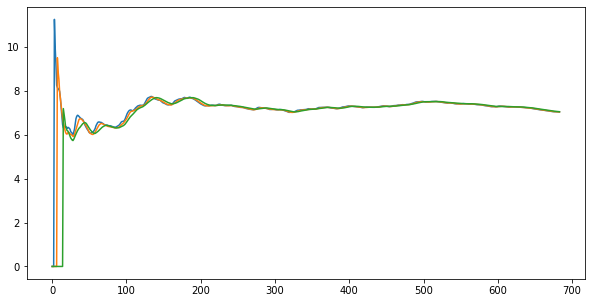

In [128]:
plt.figure(figsize=(10,5))
plt.plot(x_tr.ace_ave_roll_mean_4.values)
plt.plot(x_tr.ace_ave_roll_mean_8.values)
plt.plot(x_tr.ace_ave_roll_mean_16.values)
plt.show()

In [12]:
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats

In [13]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

In [ ]:
# def extract_stats(df, segments, features, scale=False):

#     #main dataframe for storing stats
#     X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)
    
#     for feature in features:    
#         #time series data
#         x_full = pd.Series(df[f'{feature}'].values)
        
#         if feature == 'w_age':
#             X_tr.loc[:, f'{feature[2:]}'] = x_full
#         else:
#             for segment in range(segments):
#                 if feature == 'surface':
#                     X_tr.loc[segment, f'{feature}'] = get_surface_cate(x_full[segment])
#                 elif feature == 'round':
#                     X_tr.loc[segment, f'{feature}'] = get_round_cate(x_full[segment])
#                 else:
#                     feature_name = feature[2:]
                    
#                     #take all of x until that point in time
#                     x = x_full[:segment+1]
                    
#                     #compute stats on this feature
#                     X_tr.loc[segment, f'{feature_name}_mean'] = x.mean()
#                     X_tr.loc[segment, f'{feature_name}_std'] = x.std()
#                     X_tr.loc[segment, f'{feature_name}_max'] = x.max()
#                     X_tr.loc[segment, f'{feature_name}_min'] = x.min()

#                     X_tr.loc[segment, f'{feature_name}_mean_change_abs'] = np.mean(np.diff(x))
#                     X_tr.loc[segment, f'{feature_name}_abs_max'] = np.abs(x).max()
#                     X_tr.loc[segment, f'{feature_name}_abs_min'] = np.abs(x).min()

#                     X_tr.loc[segment, f'{feature_name}_max_to_min_diff'] = x.max() - np.abs(x.min())
#                     X_tr.loc[segment, f'{feature_name}_sum'] = x.sum()

#                     X_tr.loc[segment, f'{feature_name}_q95'] = np.quantile(x, 0.95)
#                     X_tr.loc[segment, f'{feature_name}_q99'] = np.quantile(x, 0.99)
#                     X_tr.loc[segment, f'{feature_name}_q05'] = np.quantile(x, 0.05)
#                     X_tr.loc[segment, f'{feature_name}_q01'] = np.quantile(x, 0.01)

#                     X_tr.loc[segment, f'{feature_name}_abs_q95'] = np.quantile(np.abs(x), 0.95)
#                     X_tr.loc[segment, f'{feature_name}_abs_q99'] = np.quantile(np.abs(x), 0.99)
#                     X_tr.loc[segment, f'{feature_name}_abs_q05'] = np.quantile(np.abs(x), 0.05)
#                     X_tr.loc[segment, f'{feature_name}_abs_q01'] = np.quantile(np.abs(x), 0.01)

#                     X_tr.loc[segment, f'{feature_name}_mad'] = x.mad()
#                     X_tr.loc[segment, f'{feature_name}_kurt'] = x.kurtosis()
#                     X_tr.loc[segment, f'{feature_name}_skew'] = x.skew()
#                     X_tr.loc[segment, f'{feature_name}_med'] = x.median()
                    
#                     X_tr.loc[segment, f'{feature_name}_iqr'] = np.subtract(*np.percentile(x, [75, 25]))
#                     X_tr.loc[segment, f'{feature_name}_q999'] = np.quantile(x,0.999)
#                     X_tr.loc[segment, f'{feature_name}_q001'] = np.quantile(x,0.001)
#                     X_tr.loc[segment, f'{feature_name}_ave10'] = stats.trim_mean(x, 0.1)

#                     X_tr.loc[segment, f'{feature_name}_Hilbert_mean'] = np.abs(hilbert(x)).mean()
#                     X_tr.loc[segment, f'{feature_name}_Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
                    
#                     #rolling stats
#                     for windows in [2, 4, 6, 8, 10, 12, 16, 32]:
#                         x_roll_std = x.rolling(windows).std().dropna().values
#                         x_roll_mean = x.rolling(windows).mean().dropna().values

#                         X_tr.loc[segment, f'{feature_name}_ave_roll_std_' + str(windows)] = x_roll_std.mean()
#                         X_tr.loc[segment, f'{feature_name}_std_roll_std_' + str(windows)] = x_roll_std.std()
#                         X_tr.loc[segment, f'{feature_name}_av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
#                         X_tr.loc[segment, f'{feature_name}_av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
                            
#                         X_tr.loc[segment, f'{feature_name}_ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
#                         X_tr.loc[segment, f'{feature_name}_std_roll_mean_' + str(windows)] = x_roll_mean.std()
#                         X_tr.loc[segment, f'{feature_name}_av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
#                         X_tr.loc[segment, f'{feature_name}_av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
                       
#     return X_tr.fillna(value=0.0)    


In [122]:
def extract_stats(df, segments, features, scale=False):

    #main dataframe for storing stats
    X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)
    
    for feature in features:    
        #new time-series pd dataframe
        x_full = pd.Series(df[f'{feature}'].values)
        
        if feature == 'w_age':
            #no segment analysis - just the ages for each match
            X_tr.loc[:, f'{feature[2:]}'] = x_full
        else:
            for segment in range(segments):
                if feature == 'surface':
                    #get surface type (category to float conversion)
                    X_tr.loc[segment, f'{feature}'] = get_surface_cate(x_full[segment])
                elif feature == 'round':
                    #get round type (category to float conversion)
                    X_tr.loc[segment, f'{feature}'] = get_round_cate(x_full[segment])
                else:
                    #get the feature name by subtracting the "w_"
                    feature_name = feature[2:]
                    
                    #take x from first to current game (inclusive)
                    #tho input-target pairs are formed by taking stats from games BEFORE
                    #the target date
                    x = x_full[:segment+1]
                    
                    #compute stats on this feature
                    X_tr.loc[segment, f'{feature_name}_mean'] = x.mean()
                    X_tr.loc[segment, f'{feature_name}_std'] = x.std()
                    X_tr.loc[segment, f'{feature_name}_max'] = x.max()
                    X_tr.loc[segment, f'{feature_name}_min'] = x.min()

                    X_tr.loc[segment, f'{feature_name}_mean_change_abs'] = np.mean(np.diff(x))
                    X_tr.loc[segment, f'{feature_name}_abs_max'] = np.abs(x).max()
                    X_tr.loc[segment, f'{feature_name}_abs_min'] = np.abs(x).min()

                    X_tr.loc[segment, f'{feature_name}_max_to_min_diff'] = x.max() - np.abs(x.min())
                    X_tr.loc[segment, f'{feature_name}_sum'] = x.sum()

                    X_tr.loc[segment, f'{feature_name}_q95'] = np.quantile(x, 0.95)
                    X_tr.loc[segment, f'{feature_name}_q99'] = np.quantile(x, 0.99)
                    X_tr.loc[segment, f'{feature_name}_q05'] = np.quantile(x, 0.05)
                    X_tr.loc[segment, f'{feature_name}_q01'] = np.quantile(x, 0.01)

                    X_tr.loc[segment, f'{feature_name}_abs_q95'] = np.quantile(np.abs(x), 0.95)
                    X_tr.loc[segment, f'{feature_name}_abs_q99'] = np.quantile(np.abs(x), 0.99)
                    X_tr.loc[segment, f'{feature_name}_abs_q05'] = np.quantile(np.abs(x), 0.05)
                    X_tr.loc[segment, f'{feature_name}_abs_q01'] = np.quantile(np.abs(x), 0.01)

                    X_tr.loc[segment, f'{feature_name}_mad'] = x.mad()
                    X_tr.loc[segment, f'{feature_name}_kurt'] = x.kurtosis()
                    X_tr.loc[segment, f'{feature_name}_skew'] = x.skew()
                    X_tr.loc[segment, f'{feature_name}_med'] = x.median()
                    
                    X_tr.loc[segment, f'{feature_name}_iqr'] = np.subtract(*np.percentile(x, [75, 25]))
                    X_tr.loc[segment, f'{feature_name}_q999'] = np.quantile(x,0.999)
                    X_tr.loc[segment, f'{feature_name}_q001'] = np.quantile(x,0.001)
                    X_tr.loc[segment, f'{feature_name}_ave10'] = stats.trim_mean(x, 0.1)

                    X_tr.loc[segment, f'{feature_name}_Hilbert_mean'] = np.abs(hilbert(x)).mean()
                    X_tr.loc[segment, f'{feature_name}_Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
                    
                    #rolling stats
                    for windows in [2, 4, 6, 8, 10, 12, 16]:
#                         if (segment+1) >= windows:
#                             x_roll_std = x.rolling(windows).std().dropna().values
#                             x_roll_mean = x.rolling(windows).mean().dropna().values
#                         else:
#                             x_roll_std = x.rolling(segment+1).std().dropna().values
#                             x_roll_mean = x.rolling(segment+1).mean().dropna().values
                        x_roll_std = x.rolling(windows).std().dropna().values
                        x_roll_mean = x.rolling(windows).mean().dropna().values
        
                        X_tr.loc[segment, f'{feature_name}_ave_roll_std_' + str(windows)] = x_roll_std.mean()
                        X_tr.loc[segment, f'{feature_name}_std_roll_std_' + str(windows)] = x_roll_std.std()
                        X_tr.loc[segment, f'{feature_name}_av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
                        X_tr.loc[segment, f'{feature_name}_av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
                            
                        X_tr.loc[segment, f'{feature_name}_ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
                        X_tr.loc[segment, f'{feature_name}_std_roll_mean_' + str(windows)] = x_roll_mean.std()
                        X_tr.loc[segment, f'{feature_name}_av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
                        X_tr.loc[segment, f'{feature_name}_av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])

    return X_tr.fillna(value=0.0)

In [16]:
def find_id(first_name, last_name):
    return np.asarray(players.loc[(players['last_name'] == last_name) & (players['first_name'] == first_name)]['player_id'])[0]

In [17]:
def euclid_distance(x,y, opt_point=(0,1)):
    return np.sqrt((opt_point[1] - y)**2 + (opt_point[0] - x)**2)

In [18]:
def get_surface_cate(surface):
    if (surface == 'Hard'):
        return 1.0
    elif (surface == 'Clay'):
        return 2.0
    elif (surface == 'Carpet'):
        return 3.0
    elif (surface == 'Grass'):
        return 4.0
    else:
        return 0.0

In [19]:
def get_round_cate(round_):
    if (round_ == 'ER'):
        return 1.0
    elif (round_ == 'BR'):
        return 2.0
    elif (round_ == 'RR'):
        return 3.0
    elif (round_ == 'R128'):
        return 4.0
    elif (round_ == 'R64'):
        return 5.0
    elif (round_ == 'R32'):
        return 6.0
    elif (round_ == 'R16'):
        return 7.0
    elif (round_ == 'QF'):
        return 8.0
    elif (round_ == 'SF'):
        return 9.0
    elif (round_ == 'F'):
        return 10.0
    else:
        return 0.0

In [22]:
def roc_curve_(models, names, val_data, test_data, colors):
    '''
    Description: plot the ROC curves of one/multiple models included in the 'models' list
    
    models = list of models (can be just one too)
    val_data = validation data tuple like (x_val, y_val)
    test_data = test data tuple like (x_test, y_test)
    '''
    # Plot ROC curve
    plt.figure(figsize=(10,10))

    #lgbm
    for i in range(len(models)):
        
        #LGBM predictions
        try:
            y_pred_val = models[i].predict_proba(x_val)[:,1]
            y_pred_test = models[i].predict_proba(x_test)[:,1]
        except:
            y_pred_val = models[i].predict(x_val)
            y_pred_test = models[i].predict(x_test)
        
        #combine into list
        model_preds = [[y_pred_val, y_pred_test]]
        
        # Compute fpr, tpr, thresholds and roc auc
        fpr_val, tpr_val, thresholds_val = roc_curve(y_val, model_preds[i][0])
        mac_roc_auc_val = roc_auc_score(y_val, model_preds[i][0], average='macro')

        fpr_test, tpr_test, thresholds_test = roc_curve(y_test, model_preds[i][1])
        mac_roc_auc_test = roc_auc_score(y_test, model_preds[i][1], average='macro')

        #optimal threshold from ROC curve
        #minimum euclid distance between (0,1) threshold points
        min_arg_val = np.argmin(euclid_distance(fpr_val, tpr_val, opt_point=(0,1)))
        opt_thres_val = thresholds_val[min_arg_val]

        min_arg_test = np.argmin(euclid_distance(fpr_test, tpr_test, opt_point=(0,1)))
        opt_thres_test = thresholds_test[min_arg_test]

        y_pred_bin_val = y_pred_val > opt_thres_val
        acc_at_opt_val = accuracy_score(y_val, y_pred_bin_val)

        y_pred_bin_test = y_pred_test > opt_thres_val #threshold from val set since this is the hold-out set
        acc_at_opt_test = accuracy_score(y_test, y_pred_bin_test)

        plt.plot(fpr_val, tpr_val,colors[i], label=f'{names[i]} val. ROC curve; Macro AUC: {mac_roc_auc_val:0.4f}\nAcc at opt thres: {acc_at_opt_val*100:0.2f}%')
        plt.plot(fpr_test, tpr_test, f'{colors[i]}--', label=f'{names[i]} test ROC curve; Macro AUC: {mac_roc_auc_test:0.4f}\nAcc at opt thres: {acc_at_opt_test*100:0.2f}%')
        plt.plot(fpr_val[min_arg_val], tpr_val[min_arg_val], f'{colors[i]}o', label=f'{names[i]} val. optimal threshold: {opt_thres_val:0.4f}')
        plt.plot(fpr_test[min_arg_test], tpr_test[min_arg_test], f'{colors[i]}+', label=f'{names[i]} test optimal threshold: {opt_thres_test:0.4f}')

    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Archive

### Feature importance

In [167]:
#get feature columns
fcols = pid_dict['100644'].loc[:, 'surface':].columns
fcols = fcols.insert(2, 'a_rank')
fcols = fcols.insert(3, 'b_rank')

In [168]:
feature_importance = pd.DataFrame()
fold_importance = pd.DataFrame()
fold_importance["feature"] = fcols
fold_importance["importance"] = lgb_model.feature_importance()
feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

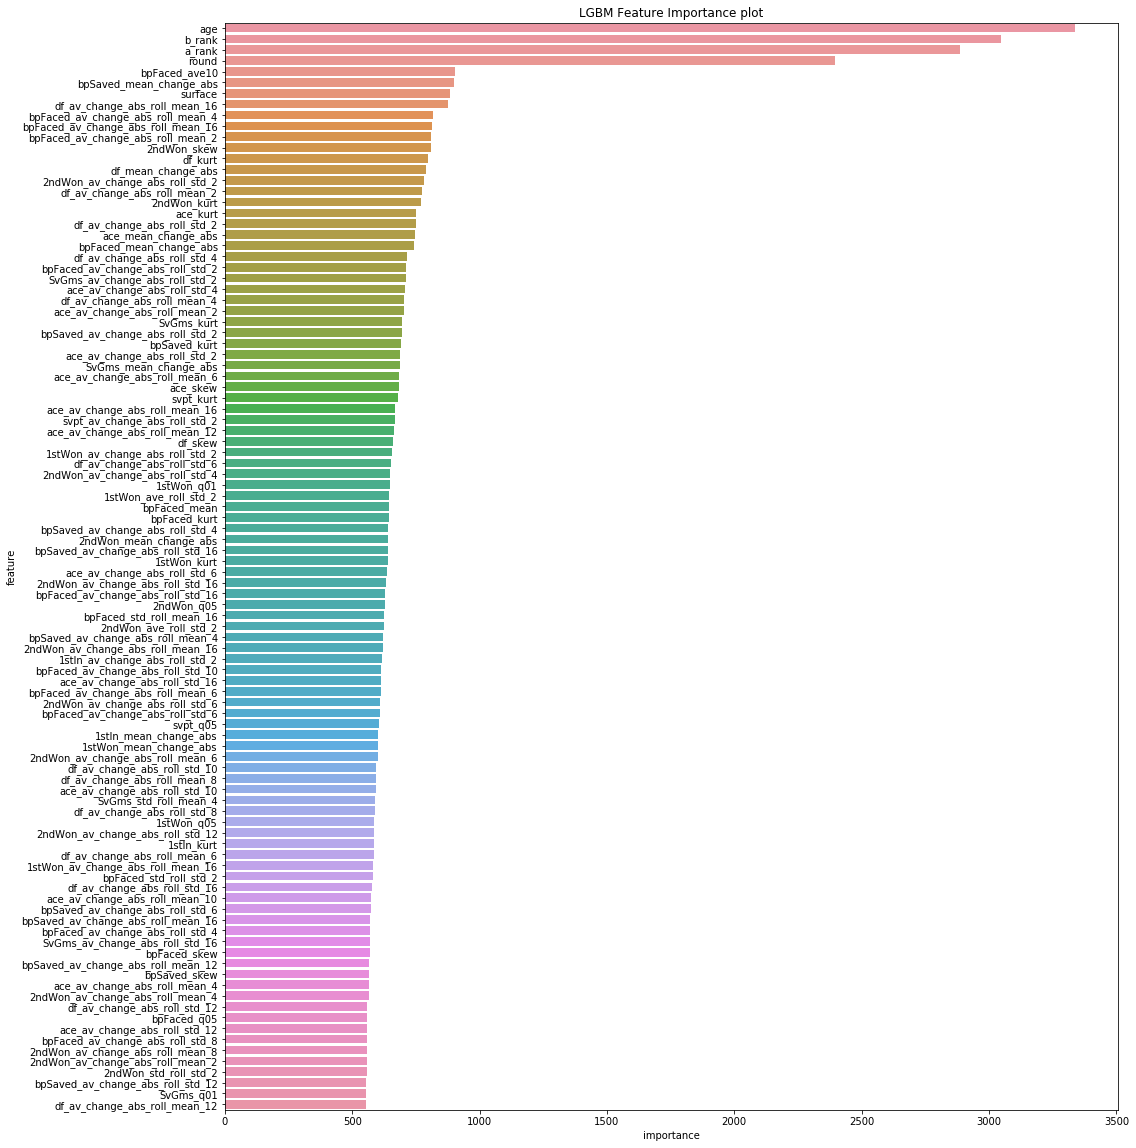

In [169]:
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:100].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 20));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGBM Feature Importance plot');

In [295]:
#get indices of top n columns
top_cols = np.argsort(-lgb_model.feature_importance())[:500]

In [ ]:
# Taking less columns seriously decreases score.
x_train_trim = x_train[:,top_cols]
x_val_trim = x_val[:,top_cols]
x_test_trim = x_test[:,top_cols]

params = {'bagging_fraction': 0.95,
          'bagging_freq': 4,
          'colsample_bytree': 0.5082709715216089,
          'learning_rate': 0.01,
          'max_depth': -1,
          'min_child_samples': 230,
          'min_child_weight': 0.1,
          'min_data_in_leaf': 41,
          'num_leaves': 134,
          'reg_alpha': 2,
          'reg_lambda': 5,
          'subsample': 0.5319087827515545} 

lgb_model_rd = lgb.LGBMClassifier(**params,
                           n_estimators = 5000,
                           n_jobs = 6, 
                           objective='binary',
                           eval_metric='auc')

lgb_model_rd.fit(x_train_trim, y_train[:,0],
              eval_set=[(x_train_trim, y_train[:,0]), (x_val_trim, y_val[:,0])],
              verbose=True,
              early_stopping_rounds=250)

In [ ]:
y_pred = lgb_model_rd.predict(x_val_trim)
print(accuracy_score(y_val, y_pred))

In [298]:
x_test_trim = x_test[:,top_cols]

In [299]:
#LGBM predictions
y_pred_val_lgbm = lgb_model_rd.predict_proba(x_val_trim)[:,1]
y_pred_test_lgbm = lgb_model_rd.predict_proba(x_test_trim)[:,1]

In [ ]:
#include all models being tested
models = ['lgbm']
colors = ['b']
model_preds = [[y_pred_val_lgbm, y_pred_test_lgbm]]

# Plot ROC curve
plt.figure(figsize=(10,10))

#lgbm
for i in range(len(models)):
    # Compute fpr, tpr, thresholds and roc auc
    fpr_val, tpr_val, thresholds_val = roc_curve(y_val, model_preds[i][0])
    mac_roc_auc_val = roc_auc_score(y_val, model_preds[i][0], average='macro')

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, model_preds[i][1])
    mac_roc_auc_test = roc_auc_score(y_test, model_preds[i][1], average='macro')

    #optimal threshold from ROC curve
    #minimum euclid distance between (0,1) threshold points
    min_arg_val = np.argmin(euclid_distance(fpr_val, tpr_val, opt_point=(0,1)))
    opt_thres_val = thresholds_val[min_arg_val]

    min_arg_test = np.argmin(euclid_distance(fpr_test, tpr_test, opt_point=(0,1)))
    opt_thres_test = thresholds_test[min_arg_test]
    
    plt.plot(fpr_val, tpr_val,colors[i], label=f'{models[i]} val. ROC curve; Macro AUC: {mac_roc_auc_val:0.4f}')
    plt.plot(fpr_test, tpr_test, f'{colors[i]}--', label=f'{models[i]} test ROC curve; Macro AUC: {mac_roc_auc_test:0.4f}')
    plt.plot(fpr_val[min_arg_val], tpr_val[min_arg_val], f'{colors[i]}o', label=f'{models[i]} val. optimal threshold: {opt_thres_val:0.4f}')
    plt.plot(fpr_test[min_arg_test], tpr_test[min_arg_test], f'{colors[i]}+', label=f'{models[i]} test optimal threshold: {opt_thres_test:0.4f}')

plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()